In [1]:
import os, json, sys, gzip, pickle
sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde
from utils import MetalElements, FunctionalGroupElements
from pymatgen.core import Element

data_root = '/home/jhyang/WORKSPACES/DATA/synthesis/SynthesisSimilarity/rsc'
os.listdir(data_root)

['ele_order_counter.json',
 'pre_count_normalized_by_rxn_ss.json',
 'data_split.npz',
 'reactions_v20_20210820_ss.jsonl']

# Raw file parsing

- raw data file

In [13]:
# raw json file
with open(f'{data_root}/reactions_v20_20210820_ss.jsonl') as f:
    full_data = [json.loads(l) for l in list(f)]

i = np.random.randint(len(full_data))

_data = full_data[36728]

#for _data in full_data:
#    if _data['doi'] != '10.1103/physrevb.95.054430':
#        continue

def print_data(dat):
    for key in ['material_string','material_formula']:
        print(key, '\t:', dat[key])
    for _d in dat['composition']:
        print('\t', _d['formula'], '/', _d['elements'])
print(i, _data['doi'])
print_data(_data['target'])
print()
for _prec in _data['precursors']: print_data(_prec)



- raw numpy file

In [15]:
# raw numpy file
npz_data = {k:v for k,v in np.load(f'{data_root}/data_split.npz', allow_pickle=True).items()}

- check data

In [16]:
# check 
for ds_rxn, ds in npz_data.items():
    for i, data in enumerate(ds):
#        n = (d['target_comp'][0] != d['target_comp_featurized'][0]).sum()
        chem = data['prototype_path'][0].split('/')[-1]
        if data['doi'] == '10.1016/j.actamat.2006.08.010':
            print(ds_rxn, i)
            for prot in data['prototype_path']:
                print(prot.split('/')[4:])

train_reactions 8866
['Mg0.3Nb0.7PbO3', 'NoDoping', 'Mg0.333Nb0.66699994Pb1O3', 'Mg0.333Nb0.66699994Pb1O3']


In [19]:
import re

re_spec = re.compile(r'\d+(\.\d+)?')
re_ele = re.compile(r'[A-Z][a-z]?')
print(chem)
chem = data['prototype_path'][0].split('/')[-1]
ns = [float(m.group()) for m in re_spec.finditer(chem)]
eles = [m.group() for m in re_ele.finditer(chem)]
print(eles, ns)
#comp = dat['target_comp'][0]
#m = comp != 0
#
#for i in np.where(m)[0]:
#    print(i, comp[i])

Y0.00200057Al0.05487283Si0.37153473N0.51443273O0.05715919
['Y', 'Al', 'Si', 'N', 'O'] [0.00200057, 0.05487283, 0.37153473, 0.51443273, 0.05715919]


In [17]:
for ds_rxn, ds in npz_data.items():
    for i, data in enumerate(ds):
        if len(data['target_comp']) != 1:
            print(ds_rxn, i, data['raw_id'])

# Parsing data

- Changing composition vector to composition dictionary
- Unfiying temperature and time scales

In [20]:
ele_dict = {i:{} for i in range(100)}
#for d in npz_data['test_reactions']:
units = {'temp':{}, 'time':{}}
for ds_rxn, dataset in npz_data.items():
    for i, data in enumerate(dataset):
        chem = data['prototype_path'][0].split('/')[-1]
        if '(' in chem: continue
        ns = [float(m.group()) for m in re_spec.finditer(chem)]
        eles = [m.group() for m in re_ele.finditer(chem)]
        if len(eles) != len(ns): continue
        comp = data['target_comp'][0]
        idxs = np.where(comp != 0)[0]
#        print(chem)
#        print(eles)
#        print(ns)
#        print(comp[idxs] * np.sum(ns))
    #    print(idxs)
        for n, ele in zip(ns, eles):
            j = np.where(np.abs(comp[idxs] * np.sum(ns) - n) < 1e-3)[0]
            if len(j) != 1:
                continue
            k = idxs[j[0]]
#            print(ele, j[0], idxs[j[0]])
            if ele not in ele_dict[k].keys():
                ele_dict[k][ele] = 0
            ele_dict[k][ele] += 1
#            if ele_dict[k][ele] < 15:
#                ele_dict[k]['ids'].append(data['doi'])
        for op in data['operations']:
            for temp in op['attributes']['temperature']:
                unit = temp['units']
                if unit not in units['temp'].keys():
                    units['temp'][unit] = 0
                units['temp'][unit] +=1
            for time in op['attributes']['time']:
                unit = time['units']
                if unit not in units['time'].keys():
                    units['time'][unit] = 0
                units['time'][unit] +=1
                

In [22]:
ele_mapper = {}
ele_indexer = [v for k,v in ele_dict.items()]
for k, v in ele_dict.items():
    if len(v.keys()) == 1:
        ele = list(v.keys())[0]
        ele_mapper[ele] = k
        ele_indexer[k] = ele

print(json.dumps(ele_dict, indent=4))
print(json.dumps(ele_mapper, indent=4))
#with open('../dump/ele_mapper.json','w') as f:
#    json.dump(ele_mapper, f, indent=4)

{
    "0": {
        "Cs": 87
    },
    "1": {
        "K": 70
    },
    "2": {
        "Rb": 24
    },
    "3": {
        "Ba": 4731
    },
    "4": {
        "Na": 1774
    },
    "5": {
        "Sr": 4884
    },
    "6": {
        "Li": 2728
    },
    "7": {
        "Ca": 4139
    },
    "8": {
        "La": 4719
    },
    "9": {
        "Tb": 466
    },
    "10": {
        "Yb": 475
    },
    "11": {
        "Ce": 1632
    },
    "12": {
        "Pr": 629
    },
    "13": {
        "Nd": 822
    },
    "14": {
        "Sm": 747
    },
    "15": {
        "Eu": 1396
    },
    "16": {
        "Gd": 1048
    },
    "17": {
        "Dy": 402
    },
    "18": {
        "Y": 2272
    },
    "19": {
        "Ho": 214
    },
    "20": {
        "Er": 267
    },
    "21": {
        "Tm": 56
    },
    "22": {
        "Lu": 330
    },
    "23": {
        "Pu": 17
    },
    "24": {
        "Am": 2
    },
    "25": {
        "Cm": 1
    },
    "26": {
        "Hf": 158
    },
    "27": 

In [24]:
#units
unit_convertors = {
    '°C': lambda x: x + 273.15,
    'C': lambda x: x + 273.15,
    'K': lambda x: x,
    'h': lambda x: x,
    'hours': lambda x: x,
    'min': lambda x: x/60,
    'day': lambda x: x * 24,
    'minutes': lambda x: x/60,
    'hr': lambda x: x,
    'd': lambda x: x * 24,    
    'hrs': lambda x: x,
    'hour': lambda x: x,
}

In [101]:
import copy

parsed_data = {}
weights = []
for k, dataset in npz_data.items():
    parsed_data[k] = []
    for data in dataset:
        _data = {}
        for key in ['id', 'raw_index', 'synthesis_type', 'doi', 'year', 'prototype_path', 'count_weight']:
            _data[key] = copy.deepcopy(data[key])
        #weights.append(data['count_weight'])
        #print(data['doi'], data['count_weight'])
        target_vec = data['target_comp'][0]
        target_comp = {ele_indexer[i]:target_vec[i] for i in np.where(target_vec)[0]}
        precursors = []
        for preccursor_vec in data['precursors_comp']:
            precursor_vec = preccursor_vec[0]
            precursor_comp = {ele_indexer[i]:precursor_vec[i] for i in np.where(precursor_vec)[0]}
            precursors.append(precursor_comp)
        _data['target_comp'] = target_comp
        _data['precursor_comp'] = precursors
        operations = []
        prev_op = None
        num_val = 0
        for op in data['operations']:
            check = False
            _op = {'type': op['type'], 'string': op['string'], 
                   'attributes':{
                       'temperature':[], 'time':[], 'env':[]
                   }}
            for attr_type in ['temperature','time']:
                for attr in op['attributes'][attr_type]:
                    _unit_converter = unit_convertors[attr['units']]
                    _min = attr['min']
                    _max = attr['max']
                    _val = attr['values'] + [_min, _max]
                    _val = sorted([_unit_converter(v) for v in set(_val) if v is not None])
                    if attr_type == 'temperature':
                        _val = [_v for _v in _val if (_v < 4000) and (_v > 0)]
                    if len(_val) == 0:
                        continue
                    _op['attributes'][attr_type].append({
                        'min':np.min(_val),
                        'max':np.max(_val),
                        'values': _val,
                        'unit':'K' if 'temp' in attr_type else 'h',
                    })
                    num_val += 1
                    if len(_val) > 3:
                        check = True
            for env in op['attributes']['environment']:
                if env == '':
                    continue
                _op['attributes']['env'].append(env)
                num_val += 1
            if num_val == 0:
                continue
            operations.append(_op)
#            if check: print(json.dumps(_op, indent=4))
        _data['operations'] = operations
        parsed_data[k].append(_data)

In [102]:
with gzip.open('../data/parsed_data.pkl.gz','wb') as f:
    pickle.dump(parsed_data, f)

# Parsed dataset

In [2]:
import gzip, pickle
with gzip.open('../data/parsed_data.pkl.gz','rb') as f:
    parsed_data = pickle.load(f)

In [95]:
for k, dataset in parsed_data.items():
    print(k, len(dataset))

train_reactions 44736
val_reactions 2254
test_reactions 2934


In [96]:
parsed_data['train_reactions'][4]

{'id': 7621,
 'raw_index': 5465,
 'synthesis_type': 'solid_state_ceramic_synthesis',
 'doi': '10.1007/bf00551283',
 'year': 1988,
 'prototype_path': ['AllMaterials/oxides/ternary/Others/BaFe12O19/NoDoping/BaFe12O19/BaFe12O19'],
 'count_weight': 1.0,
 'target_comp': {'Ba': 0.03125, 'Fe': 0.375, 'O': 0.59375},
 'precursor_comp': [{'Ba': 0.2, 'C': 0.2, 'O': 0.6}, {'Fe': 0.4, 'O': 0.6}],
 'operations': [{'type': 'DryingOperation',
   'string': 'dried',
   'attributes': {'temperature': [{'min': 383.15,
      'max': 383.15,
      'values': [383.15],
      'unit': 'K'}],
    'time': [{'min': 12.0, 'max': 12.0, 'values': [12.0], 'unit': 'h'}],
    'env': []}},
  {'type': 'HeatingOperation',
   'string': 'sintered',
   'attributes': {'temperature': [{'min': 1373.15,
      'max': 1573.15,
      'values': [1373.15, 1573.15],
      'unit': 'K'}],
    'time': [],
    'env': []}}]}

## operations

In [4]:
operations = {}
temp_vals = {}
time_vals = {}
# count op.
count_ops = {} # 0: heating, 1: mixing
# check for heating op.
temp_dist = {}
time_dist = {}
for k, dataset in parsed_data.items():
    operations[k] = {}
    temp_vals[k] = {}
    time_vals[k] = {}
    count_ops[k] = {i:[0,0,0] for i in range(20)}
    temp_dist[k] = []
    time_dist[k] = []
    for data in dataset:
        ns = [0,0]
        for op in data['operations']:
            op_type = op['type']
            if op_type not in operations[k].keys():
                operations[k][op_type] = 0
                temp_vals[k][op_type] = []
                time_vals[k][op_type] = []
            # count operation
            operations[k][op_type] += 1
            # temp. & time values
            for t in op['attributes']['temperature']:
                v = t['values']
                if len(v) == 0: continue
                temp_vals[k][op_type].extend(t['values'])
                if 'Heating' in op_type:
                    if len(v) == 1:
                        temp_dist[k].append([0,0,1])
                    else:
                        temp_dist[k].append([np.mean(v), np.max(v) - np.min(v), len(v)])
            for t in op['attributes']['time']:
                v = t['values']
                if len(v) == 0: continue
                time_vals[k][op_type].extend(t['values'])
                if 'Heating' in op_type:
                    if len(v) == 1:
                        time_dist[k].append([0,0,1])
                    else:
                        time_dist[k].append([np.mean(v), np.max(v) - np.min(v), len(v)])
            # check whether temp. (or time) is exist or not in datapoint (heating only)
            if ('Heating' in op_type) and len(op['attributes']['temperature']) != 0:
                ns[0] += 1
            if ('Mixing' in op_type) and len(op['attributes']['temperature']) != 0:
                ns[1] += 1
        if sum(ns) > 10:
            print(json.dumps(data['operations'], indent=4))
        count_ops[k][ns[0]][0] += 1
        count_ops[k][ns[1]][1] += 1
        count_ops[k][sum(ns)][2] += 1
#                has_temp[k][len(op['attributes']['temperature'])] += 1
#                has_time[k][len(op['attributes']['time'])] += 1

In [5]:
s = ' '*15 + ' / type '
keys = list(operations['train_reactions'].keys())
for key in keys:
    s += f'{key.split("Op")[0].split("Syn")[0]:>15s}'
print(s)

for ds in operations.keys():
    s = [f'{ds:15s}'] * 3
    s[0] += ' / Op.  '
    s[1] += ' / Tmp. '
    s[2] += ' / Time '
    for key in keys:
        s[0] += f'{operations[ds][key]:15d}'
        s[1] += f'{len(temp_vals[ds][key]):15d}'
        s[2] += f'{len(time_vals[ds][key]):15d}'
    for _s in s: print(_s)
    print()

                / type          Drying        Heating         Mixing        Shaping      Quenching       Starting
train_reactions / Op.            11768          71190          58964          17620          13163            802
train_reactions / Tmp.            4219          69577           1168              0           8791              0
train_reactions / Time            2705          55868          14572              0            586              0

val_reactions   / Op.              543           3420           3301            717            875             20
val_reactions   / Tmp.             177           3232             73              0            699              0
val_reactions   / Time             111           2663            737              0             41              0

test_reactions  / Op.              596           4482           4367            787           1209             76
test_reactions  / Tmp.             212           3982             78              0   

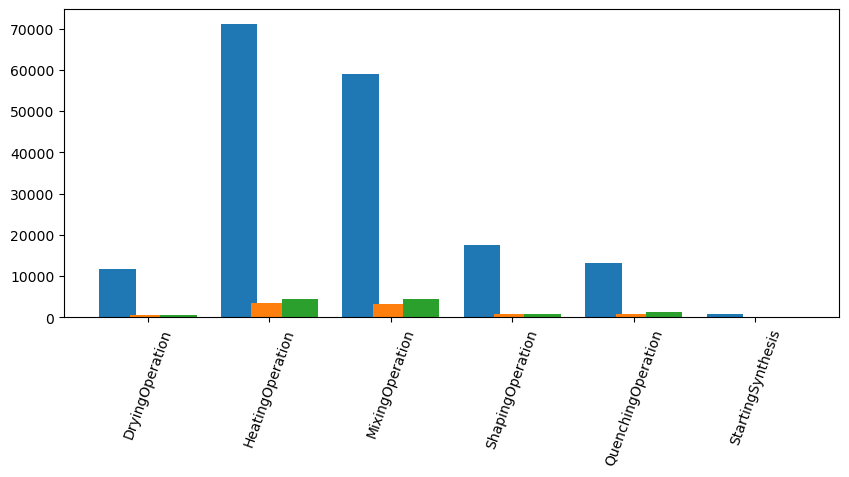

In [6]:
f, ax = plt.subplots(1,1,figsize=(10,4))
keys = list(operations['train_reactions'].keys())
for i, op in enumerate(operations.values()):
    for j, key in enumerate(keys):
        val = op.get(key)
        ax.bar(j+(i-1)*0.25, val, width=0.3, color=mpl.cm.tab10(i))
_ = ax.set_xticks(np.arange(len(keys)), labels=keys, rotation=70)

- Temp. and Time dist.

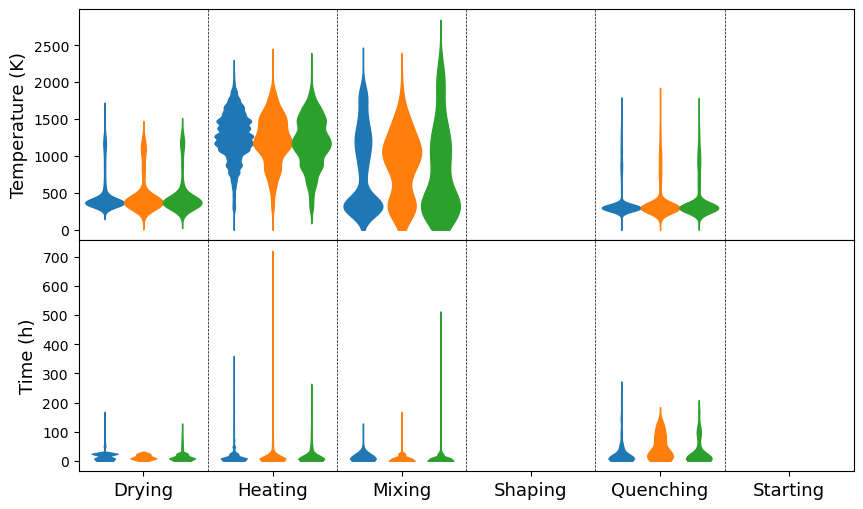

In [198]:
f, ax = plt.subplots(2,1,figsize=(10,6), sharex=True)
y = np.linspace(0,4000,500)
for i, ds in enumerate(operations.keys()):
    for j, key in enumerate(keys):
        t1 = temp_vals[ds][key]
        t2 = time_vals[ds][key]
        k = j + (i-1) * 0.3
        if len(t1) != 0:
            x = gaussian_kde(t1)(y)
            x = x/np.max(x) * 0.15
            m = x > 1e-4
            ax[0].fill_betweenx(y[m], -x[m]+k, x[m]+k, color=mpl.cm.tab10(i))
        if len(t2) != 0:
            x = gaussian_kde(t2)(y)
            x = x/np.max(x) * 0.1
            m = x > 1e-4
            ax[1].fill_betweenx(y[m], -x[m]+k, x[m]+k, color=mpl.cm.tab10(i))
for _ax in ax: 
    _ax.set_xlim([-0.5, 5.5])
    [_ax.axvline(i+0.5, ls='--', lw=0.5, color=[0,0,0]) for i in range(5)]
ax[1].set_xticks(np.arange(len(keys)), labels=[k.split('O')[0].split('Syn')[0] for k in keys], fontsize=13)
ax[0].set_ylabel('Temperature (K)', fontsize=13)
ax[1].set_ylabel('Time (h)', fontsize=13)
f.subplots_adjust(hspace=0)

- Heating Op. temp. & time dist.

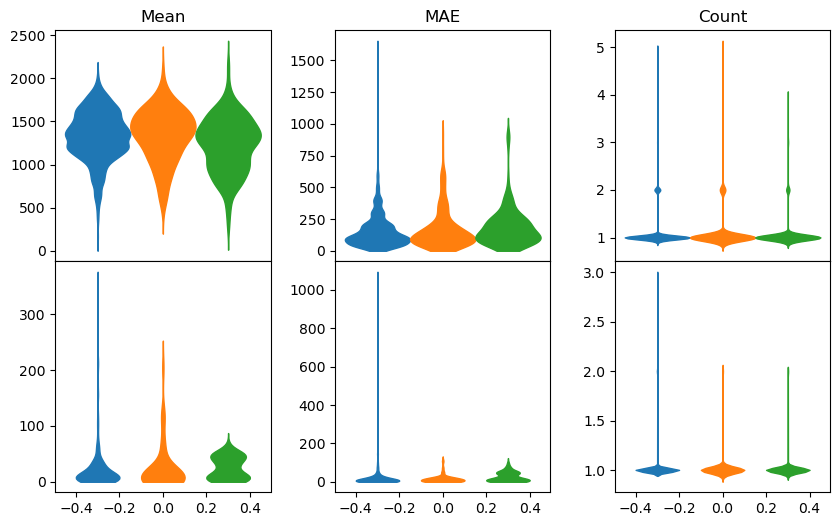

In [206]:
f, axs = plt.subplots(2,3,figsize=(10,6), sharex=True)
for i, ds in enumerate(operations.keys()):
    k = (i-1) * 0.3
    for j, vs in enumerate(np.array(temp_dist[ds]).T):
        y = np.linspace(0,3000,500)
        if j == 2:
            y = np.linspace(0,10,500)
        x = gaussian_kde(vs[vs != 0])(y)
        x = x/np.max(x) * 0.15
        m = x > 1e-4
        axs[0, j].fill_betweenx(y[m], -x[m]+k, x[m]+k, color=mpl.cm.tab10(i))
    for j, vs in enumerate(np.array(time_dist[ds]).T):
        y = np.linspace(0,1500,500)
        if j == 2:
            y = np.linspace(0,10,500)
        x = gaussian_kde(vs[vs != 0])(y)
        x = x/np.max(x) * 0.1
        m = x > 1e-4
        axs[1, j].fill_betweenx(y[m], -x[m]+k, x[m]+k, color=mpl.cm.tab10(i))
axs[0,0].set_title('Mean')
axs[0,1].set_title('MAE')
axs[0,2].set_title('Count')
f.subplots_adjust(hspace=0, wspace=0.3)

## Targets & Precursors

In [17]:
chem_format = '{}={:.3f}'
AllElements = MetalElements + FunctionalGroupElements

count_ele = {e:[0,0,0] for e in sorted(AllElements, key=lambda x: Element(x).number)}
count_target = {}
count_target_system = {}
count_prec = {}
count_prec_system = {}
count_tgt_eles = {e:{'count':[0,0,0], 'case':{}} for e in sorted(MetalElements, key=lambda x: Element(x).number)}
count_tgt_eles.update({'None':{'count':[0,0,0], 'case':{}}})
count_fg_eles = {}
count_multiple_prec_case = {e:np.zeros((3,8)) for e in sorted(MetalElements, key=lambda x: Element(x).number)}
count_multiple_prec_case.update({'None':np.zeros((3,8))})
for i, dataset in enumerate(parsed_data.values()):
    # loop over data
    for data in dataset:
        # get target material in string
        target_comp = {e:v for e,v in sorted(data['target_comp'].items(), key=lambda x: Element(x[0]).number)}
        prec_comps = [{e:v for e,v in sorted(prec_comp.items(), key=lambda x: Element(x[0]).number)} for prec_comp in data['precursor_comp']]
        
        target_string = '_'.join([chem_format.format(e,v) for e,v in target_comp.items() if v > 0.001])
        target_eles = tuple(list(target_comp.keys()))
        if target_string not in count_target.keys():
            count_target[target_string] = [0,0,0]
        count_target[target_string][i] += 1
        if target_eles not in count_target_system.keys():
            count_target_system[target_eles] = [0,0,0]
        count_target_system[target_eles][i] += 1

        _num_prec = {e:0 for e in target_comp.keys() if e in MetalElements}
        _num_prec.update({'None':0})
        for prec_comp in prec_comps:
            prec_string = '_'.join([chem_format.format(e,v) for e,v in prec_comp.items() if v > 0.001])
            prec_eles = tuple(list(prec_comp.keys()))
            prec_fg_eles = tuple([e for e in prec_comp.keys() if e not in MetalElements])
            prec_fg_comp_string = '_'.join([f'{v:.3f}' for e, v in prec_comp.items() if (e not in MetalElements) and (v > 0.001)])
            prec_metal_eles = [e for e in prec_comp.keys() if e in MetalElements]
            if len(prec_metal_eles) > 1: # if multiple metallic element
                print(prec_comp)
            prec_metal_ele = prec_metal_eles[0] if len(prec_metal_eles) != 0 else 'None'
            
            if prec_string not in count_prec.keys():
                count_prec[prec_string] = [0,0,0]
            count_prec[prec_string][i] += 1
            if prec_eles not in count_prec_system.keys():
                count_prec_system[prec_eles] = [0,0,0]
            count_prec_system[prec_eles][i] += 1
            if prec_fg_eles not in count_tgt_eles[prec_metal_ele]['case'].keys():
                count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles] = {'count':[0,0,0], 'case':{}}
            if prec_fg_comp_string not in count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles]['case'].keys():
                count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles]['case'][prec_fg_comp_string] = [0,0,0]
            count_tgt_eles[prec_metal_ele]['count'][i] += 1
            count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles]['count'][i] += 1
            count_tgt_eles[prec_metal_ele]['case'][prec_fg_eles]['case'][prec_fg_comp_string][i] += 1
            
            if prec_fg_eles not in count_fg_eles.keys():
                count_fg_eles[prec_fg_eles] = {'count':[0,0,0], 'case':{}}
            if prec_fg_comp_string not in count_fg_eles[prec_fg_eles]['case'].keys():
                count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string] = {'count':[0,0,0], 'case':{}}
            if prec_metal_ele not in count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string]['case'].keys():
                count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string]['case'][prec_metal_ele] = 0
            count_fg_eles[prec_fg_eles]['count'][i] += 1
            count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string]['count'][i] += 1
            count_fg_eles[prec_fg_eles]['case'][prec_fg_comp_string]['case'][prec_metal_ele] += 1
            
            _num_prec[prec_metal_ele] += 1
        for e, v in _num_prec.items():
            if e == 'None' and v == 0: continue
            count_multiple_prec_case[e][i, v] += 1

- \# of target & precursors

In [4]:
print('Count by target composition', len(count_target))
print('Count by target element', len(count_target_system))
print('Count by precursor composition', len(count_prec))
print('Count by precursor element', len(count_prec_system))

fg_sys = []
for v in count_tgt_eles.values():
    for k in v['case'].keys():
        if k not in fg_sys:
            fg_sys.append(k)

print('Count by precursor functional group element', len(fg_sys))

Count by target composition 27854
Count by target element 9557
Count by precursor composition 1037
Count by precursor element 665
Count by precursor functional group element 59


- \# of elements in target compounds & precursors

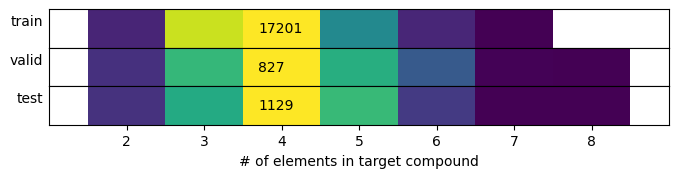

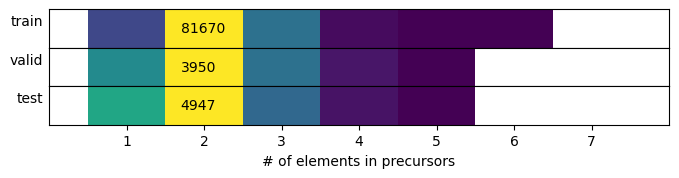

In [341]:
mat = np.zeros((3,10))
cmap = mpl.cm.viridis
cmap.set_under([1,1,1])
ylabels = ['train','valid','test']
for sys, count in count_target_system.items():
    n_ele = len(sys)
    mat[:, n_ele] += count
f, axs = plt.subplots(3,1,figsize=(8,1.5), sharex=True)
for ax, m, ylabel in zip(axs, mat, ylabels):
    ax.pcolormesh([m], cmap=cmap, vmin=1)
    ax.text(np.argmax(m)+0.2, 0.4, f'{np.max(m):.0f}')
    ax.set_xticks(np.arange(2,9) + 0.5, labels=[str(i) for i in range(2,9)])
    ax.set_xlim(1.5,9.5)
    ax.set_yticks([])
    ax.set_ylabel(ylabel, rotation=0, ha='right')
ax.set_xlabel('# of elements in target compound')
f.subplots_adjust(hspace=0)

mat = np.zeros((3,10))
for sys, count in count_prec_system.items():
    n_ele = len(sys)
    mat[:, n_ele] += count
f, axs = plt.subplots(3,1,figsize=(8,1.5), sharex=True)
for ax, m, ylabel in zip(axs, mat, ylabels):
    ax.pcolormesh([m], cmap=cmap, vmin=1)
    ax.text(np.argmax(m)+0.2, 0.4, f'{np.max(m):.0f}')
    ax.set_xticks(np.arange(1,8) + 0.5, labels=[str(i) for i in range(1,8)])
    ax.set_xlim(0.5,8.5)
    ax.set_yticks([])
    ax.set_ylabel(ylabel, rotation=0, ha='right')
ax.set_xlabel('# of elements in precursors')
f.subplots_adjust(hspace=0)


quatenary가 가장 많음. 

- \# of precursors used for metal element in single reaction

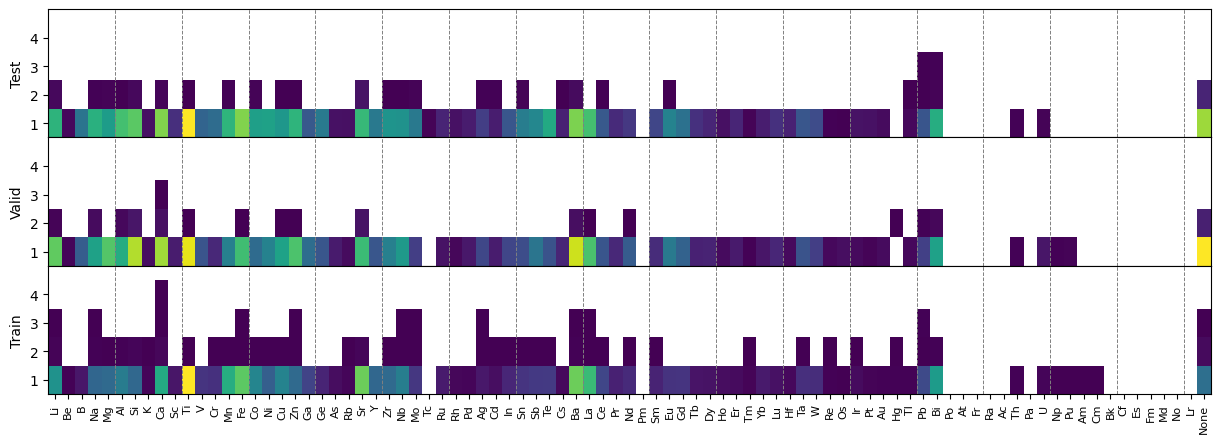

In [286]:
f, axs = plt.subplots(3,1,figsize=(15,5), sharex=True)
cmap = mpl.cm.viridis
cmap.set_under([1,1,1])
ele = list(count_multiple_prec_case.keys())
mat = np.array([v for v in count_multiple_prec_case.values()]).transpose(1,0,2)
for ax, v in zip(axs[::-1], mat):
    ax.pcolormesh(v.T, vmin=1, cmap=cmap)
    [ax.axvline(i*5, ls='--', color=[0.5, 0.5, 0.5], lw=0.7) for i in range(1,18)]
    ax.set_yticks(np.arange(1,5)+0.5, labels=[str(i) for i in range(1,5)])
    ax.set_ylim([1, 5.5])
axs[2].set_xticks(np.arange(len(ele))+0.5, labels=ele, rotation=90, fontsize=8)
axs[0].set_ylabel('Test')
axs[1].set_ylabel('Valid')
axs[2].set_ylabel('Train')
f.subplots_adjust(hspace=0)

2종 이상의 프리커서가 사용된 경우 다수 존재함

- \# of functional groups (by consisting elements) used for precursors

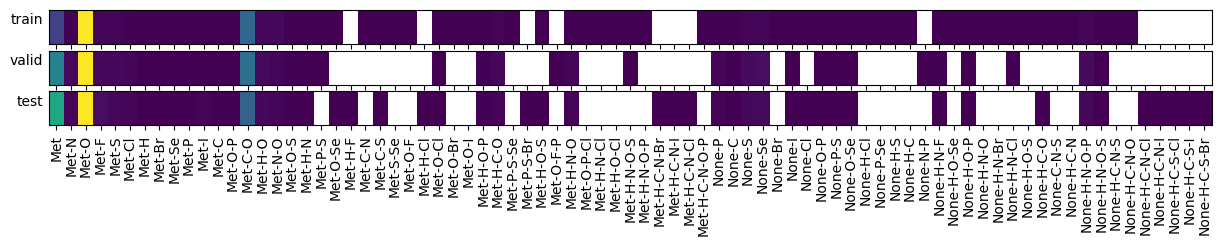

In [11]:
prec_system = {}
for metal, v in count_tgt_eles.items():
    ele = ('Met',)
    if metal == 'None':
        ele = ('None',)
    for fg_sys, v2 in v['case'].items():
        key = ele + fg_sys
        if key not in prec_system.keys():
            prec_system[key] = np.zeros(3)
        prec_system[key] += np.array(v2['count'])

prec_system = {k:v for k,v in sorted(sorted(prec_system.items(), key=lambda x: len(x[0])), key=lambda x: x[0][0])}
xticks = ['-'.join(list(k)) for k in prec_system.keys()]
mat = np.array(list(prec_system.values())).T

cmap = mpl.cm.viridis
cmap.set_under([1,1,1])
ylabels = ['train','valid','test']
f, axs = plt.subplots(3,1,figsize=(15,1.5), sharex=True)
for ax, m, ylabel in zip(axs, mat, ylabels):
#    m[m == 0] = 1e-5
#    m = np.log10(m)
    ax.pcolormesh([m], cmap=cmap, vmin=1)
#    ax.text(np.argmax(m)+0.2, 0.4, f'{np.max(m):.0f}')
    ax.set_xticks(np.arange(len(xticks)) + 0.5, labels=xticks, rotation=90)
    ax.set_ylabel(ylabel, rotation=0, ha='right')
    ax.set_yticks([])

- by log scale

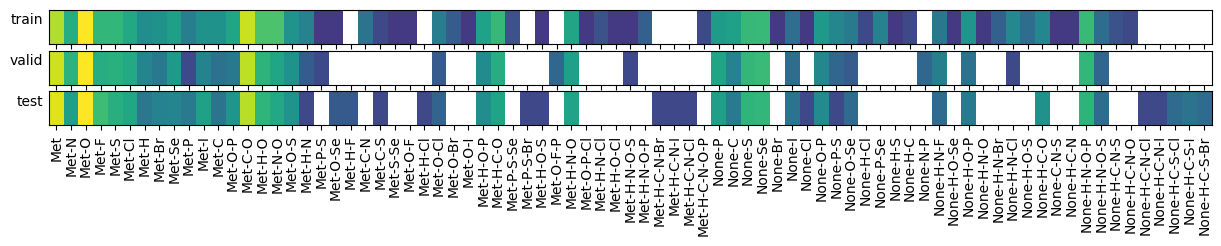

In [12]:
cmap = mpl.cm.viridis
cmap.set_under([1,1,1])
ylabels = ['train','valid','test']
f, axs = plt.subplots(3,1,figsize=(15,1.5), sharex=True)
for ax, m, ylabel in zip(axs, mat, ylabels):
    m[m == 0] = 1e-5
    m = np.log10(m)
    ax.pcolormesh([m], cmap=cmap, vmin=-1)
#    ax.text(np.argmax(m)+0.2, 0.4, f'{np.max(m):.0f}')
    ax.set_xticks(np.arange(len(xticks)) + 0.5, labels=xticks, rotation=90)
    ax.set_ylabel(ylabel, rotation=0, ha='right')
    ax.set_yticks([])

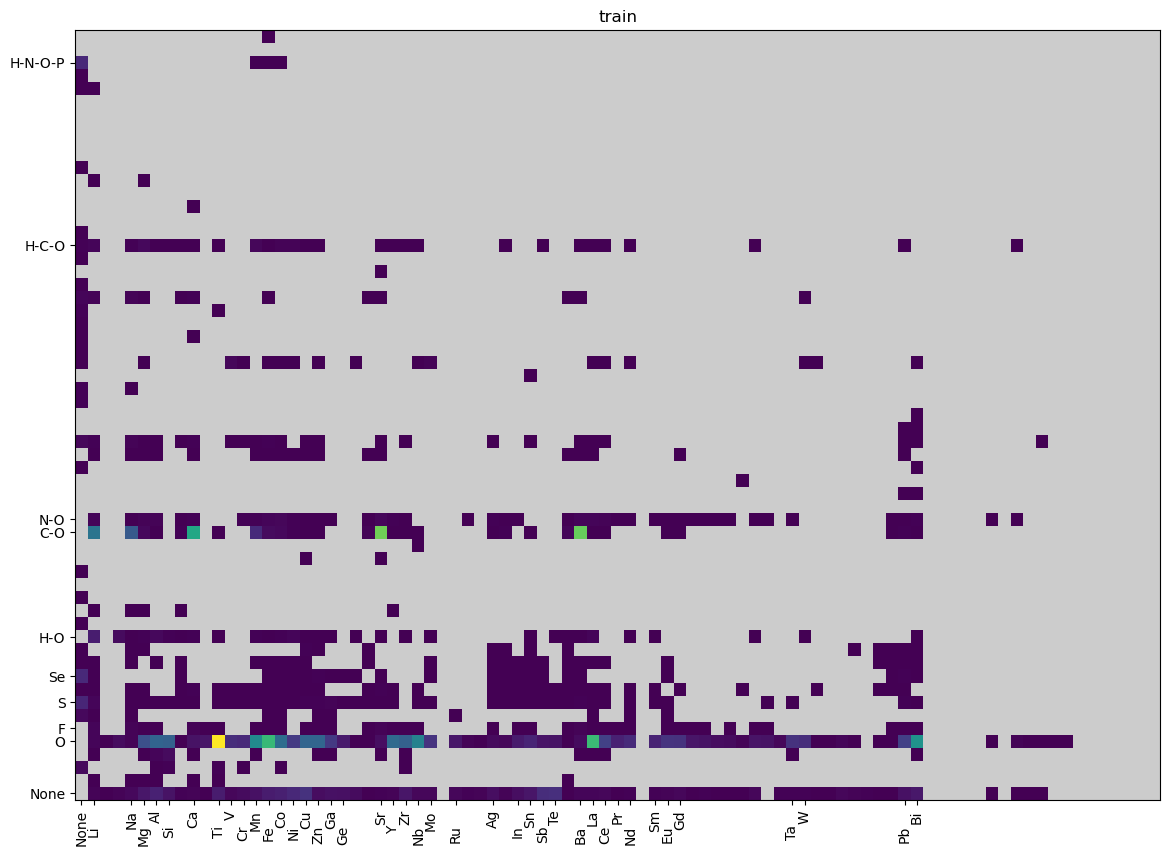

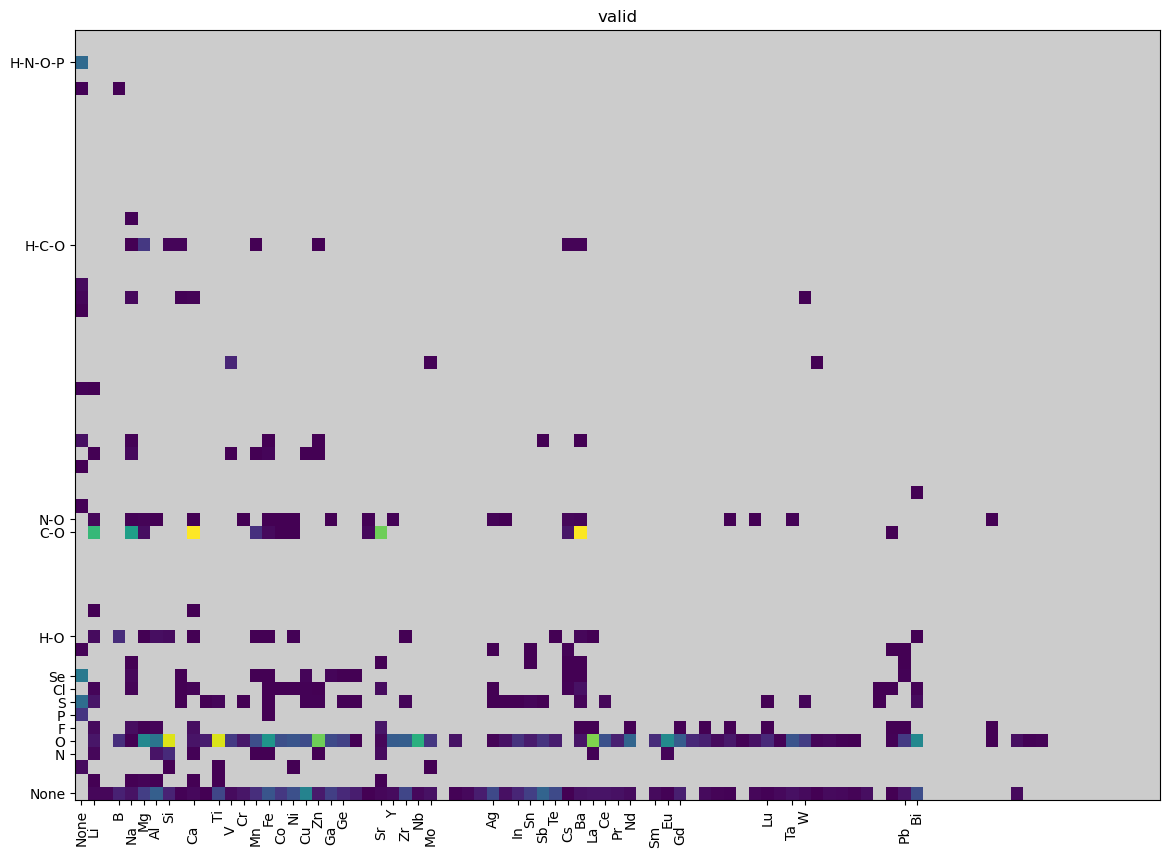

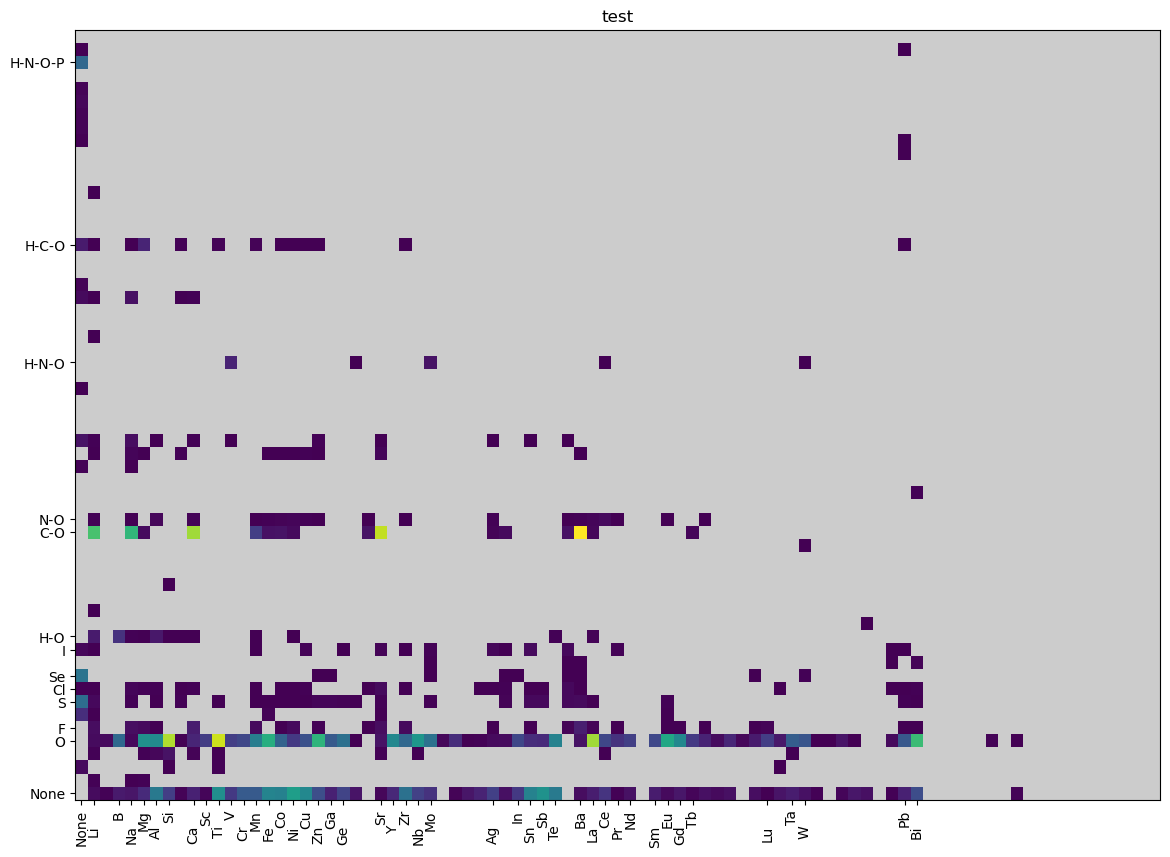

In [124]:
metals = ['None']
metals += list(count_tgt_eles.keys())[:-1]
fg_sys = [tuple()]
fg_sys += sorted(sorted(set([k[1:] for k in prec_system.keys() if len(k) > 1]), key=lambda x: Element(x[0]).number), key=lambda x:len(x))

mat = np.zeros((3, len(metals), len(fg_sys)))
for i, m in enumerate(metals):
    c = count_tgt_eles.get(m)
    if c is None: continue
    for j, fg in enumerate(fg_sys):
        if c['case'].get(fg) is None:
            continue
        count = c['case'].get(fg)['count']
        mat[:, i, j] += np.array(count)

cmap = mpl.cm.viridis
cmap.set_under([0.8,0.8,0.8])
ylabels = ['train','valid','test']
yticks = ['-'.join(list(k)) for k in fg_sys]
yticks[0] = 'None'
for m, ylabel in zip(mat, ylabels):
    f, ax = plt.subplots(1,1,figsize=(14,10))
    ax.set_title(ylabel)
    ax.pcolormesh(m.T, vmin=1, cmap=cmap)
    y_mask = m.sum(0) > np.sum(m) * 0.005
    ax.set_yticks(np.where(y_mask)[0] + 0.5, labels=np.array(yticks)[y_mask])
    x_mask = m.sum(1) > np.sum(m) * 0.005
    ax.set_xticks(np.where(x_mask)[0] + 0.5, labels=np.array(metals)[x_mask], rotation=90)
    for i, t in enumerate(ax.get_xticklabels()):
        if i % 2 == 0: continue
        t.set_y(-0.02)

### frequency-based precursor information

In [21]:
precursor_usage_freqeuncy = {}
functionalgroup_usage_frequency = {}
total_precursor_used = np.sum([np.sum(v['count']) for v in count_tgt_eles.values()])

for metal, prec_info in count_tgt_eles.items():
    total_metal_used = np.sum(prec_info['count'])
    for func_group, func_info in prec_info['case'].items():
        total_func_used = np.sum(func_info['count'])
        for comp, count in func_info['case'].items():
            pass
#functional_group_info['case']
metal, total_metal_used, func_group, total_func_used, comp, count


('None', 4643, ('H', 'C', 'S', 'Br'), 4, '0.643_0.214_0.071_0.071', [0, 0, 4])

In [20]:
count_fg_eles[('O',)]

{'count': [78466, 3578, 4495],
 'case': {'0.600': {'count': [33460, 1471, 1990],
   'case': {'Y': 3101,
    'Cr': 1009,
    'Fe': 5886,
    'In': 731,
    'Ga': 1533,
    'Al': 2946,
    'La': 6245,
    'Gd': 1428,
    'Sc': 563,
    'Bi': 4652,
    'Ho': 288,
    'Yb': 495,
    'Mn': 1152,
    'B': 381,
    'Eu': 1549,
    'Lu': 498,
    'Nd': 1164,
    'Sm': 920,
    'Sb': 318,
    'Pr': 104,
    'As': 10,
    'Co': 646,
    'Ni': 80,
    'Ti': 50,
    'Dy': 471,
    'Er': 305,
    'Tm': 80,
    'Tl': 28,
    'Rh': 95,
    'Tb': 45,
    'Nb': 19,
    'Re': 8,
    'V': 78,
    'Pb': 3,
    'Ta': 6,
    'Mo': 13,
    'Zr': 2,
    'Ru': 2,
    'Ca': 1,
    'Ge': 5,
    'Ba': 3,
    'Ce': 4,
    'W': 2,
    'Sr': 2}},
  '0.667': {'count': [20421, 906, 1142],
   'case': {'Si': 3120,
    'Zr': 2726,
    'Te': 553,
    'Ti': 8927,
    'Hf': 174,
    'Ge': 728,
    'Ce': 1750,
    'Sn': 862,
    'Mn': 2363,
    'U': 53,
    'Ru': 564,
    'Ba': 113,
    'Mo': 24,
    'Nb': 11,
    'V': 23,
 

## Temperature-materials correlation (TODO)

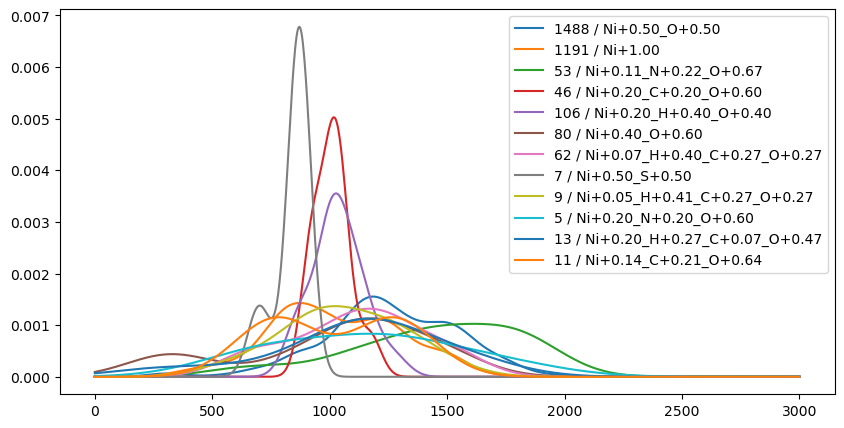

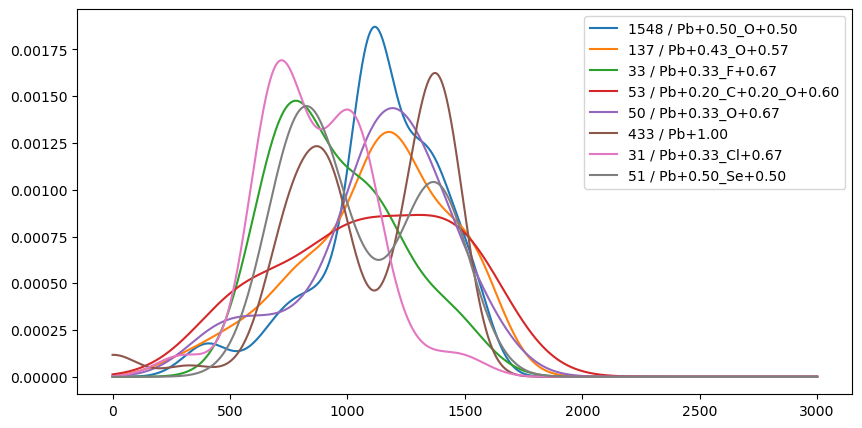

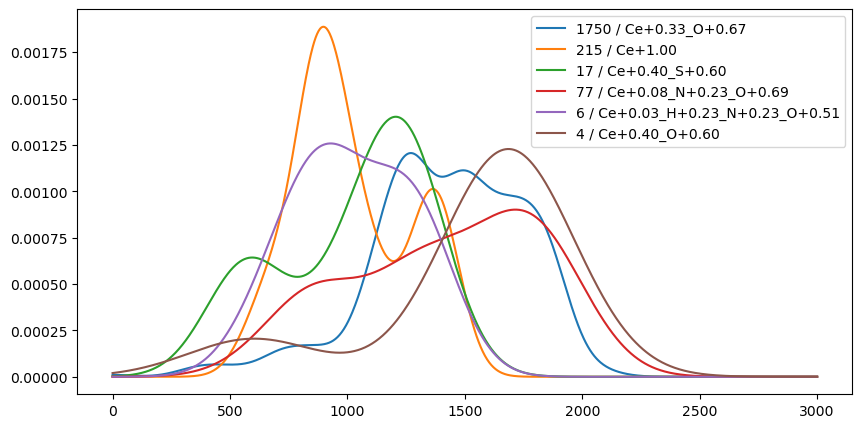

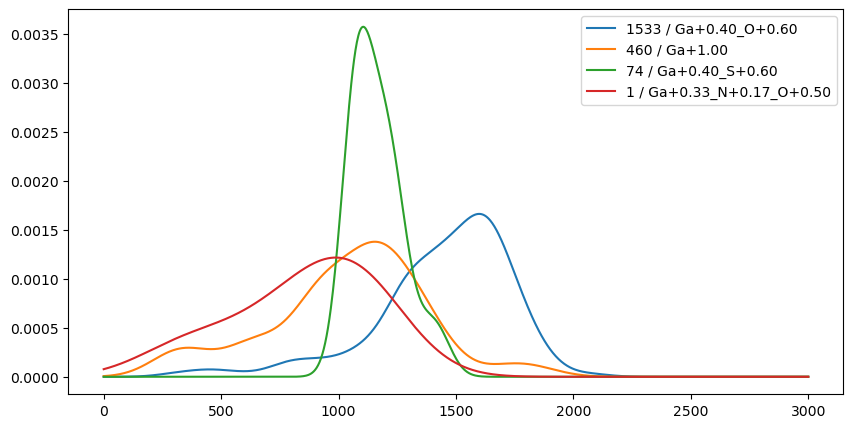

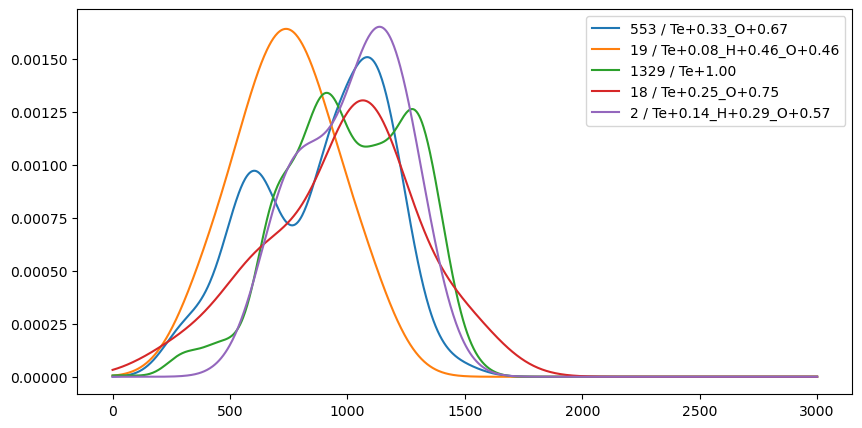

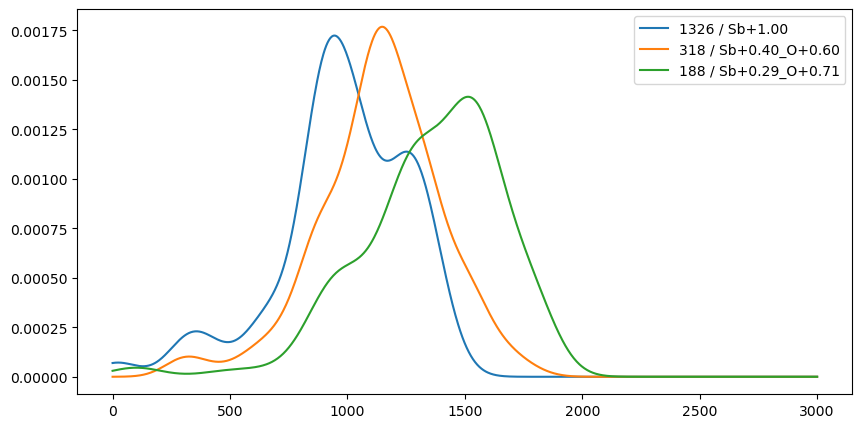

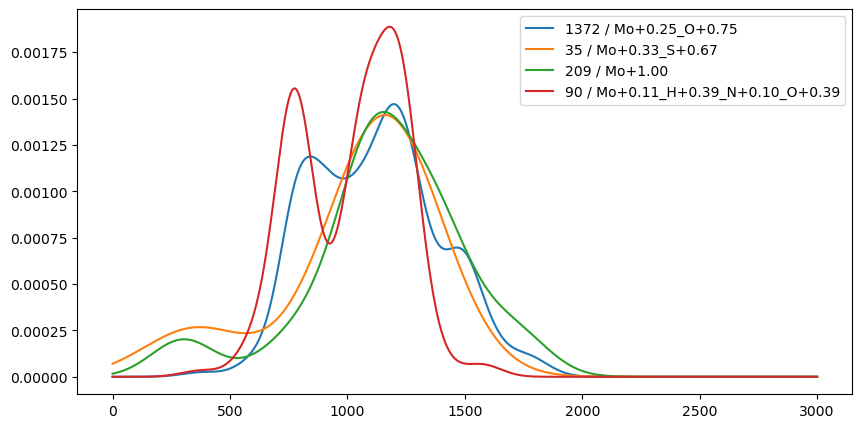

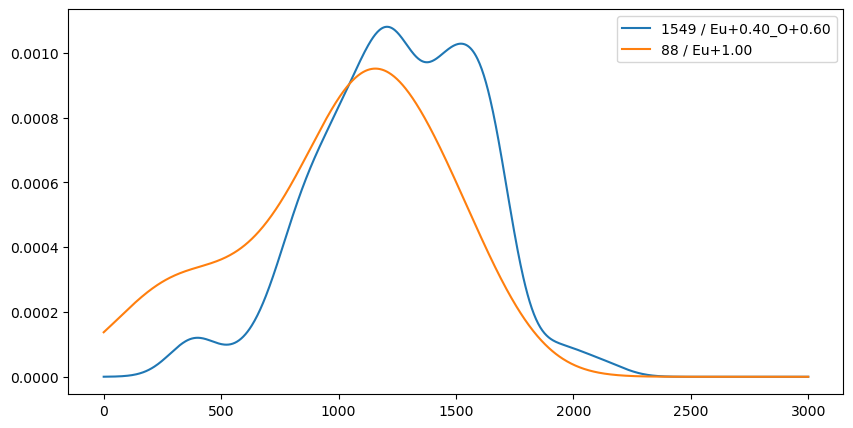

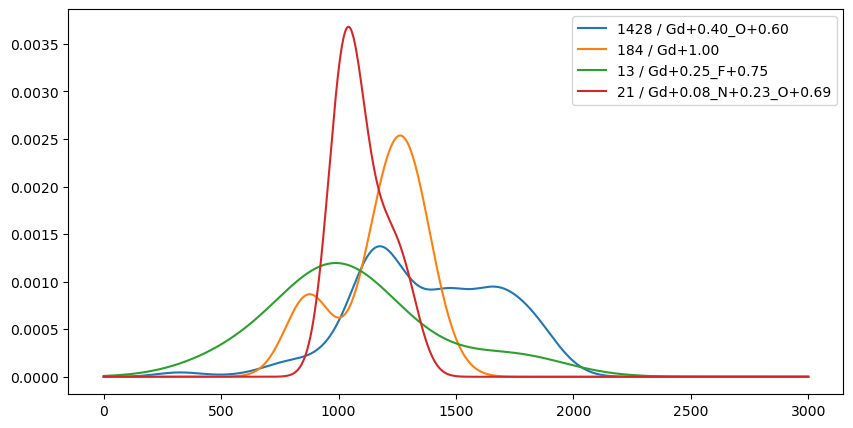

In [319]:
view_eles = ['Ti', 'Sr', 'Ba', 'Fe', 'La', 'Ca', 'Mn', 'Bi', 'Li']
view_eles = ['Ni','Pb','Ce','Ga','Te','Sb','Mo','Eu','Gd',]

#mat_by_prec = {k:v for k,v in sorted(mat_by_prec.items(), key=lambda x: x[1]['count'], reverse=True)}
for view_ele in view_eles:
    f, ax = plt.subplots(1,1,figsize=(10,5))
    for k,v in mat_by_prec.items():
        if view_ele not in k: continue
        if len(v['ops']) < 5: continue
        vs = np.hstack(v['ops'])
        if len(vs) < 5: continue
        g = gaussian_kde(vs)
        ax.plot(x, g(x), label=f'{v["count"]} / {k}')
    ax.legend(loc='upper right')